In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import io
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap
from urllib.request import urlopen, Request
from PIL import Image

%matplotlib inline

In [10]:
def image_spoof(self, tile):
    url = self._image_url(tile) # Obtiene Url de la API
    req = Request(url) # Realiza el request
    req.add_header('User-agent','Anaconda 3') # Usuario 
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # Obtiene Mapa
    fh.close() # Cierra Conexión
    img = Image.open(im_data) # Utiliza la lib PIL para abrir la imagen
    img = img.convert(self.desired_tile_form) # Configura la formatación de la imagen
    return img, self.tileextent(tile), 'lower' # Reformatea para usar Cartopy

def registerColorMap(count, typeCmap = 'gray', nameNewCmap = ''):
    ncolors = int(count.max())
    color_array = plt.get_cmap(typeCmap)(range(ncolors))
    
    # Cambia transparencia de los colores (alpha) considerando el mayor número de repeticiones
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

    # Crea el ColorMap Object
    nameNewCmap = typeCmap + '_' if nameNewCmap == '' else nameNewCmap
    
    return LinearSegmentedColormap.from_list(name=nameNewCmap, colors=color_array), nameNewCmap

In [11]:
PATH_DADOS = '../dados/'
PATH_FIGURE = '../figure/'
FILE_DATOS_ESTACION = 'events_MM_nxny1426.csv'

In [12]:
df = pd.read_csv(PATH_DADOS + FILE_DATOS_ESTACION, 
                 sep = ';', 
#                  parse_dates = ["date_min_t", "date_max_dt"],
#                  date_parser = lambda col: pd.to_datetime(col)
                )

In [8]:
df_aux = df.groupby(['lon_t', 'lat_t']).agg(['count']).reset_index()
df_aux = df_aux[['lon_t', 'lat_t', 'date_min_t']]
df_aux_dt = df.groupby(['lon_dt', 'lat_dt']).agg(['count']).reset_index()
df_aux_dt = df_aux_dt[['lon_dt', 'lat_dt', 'date_min_t']]

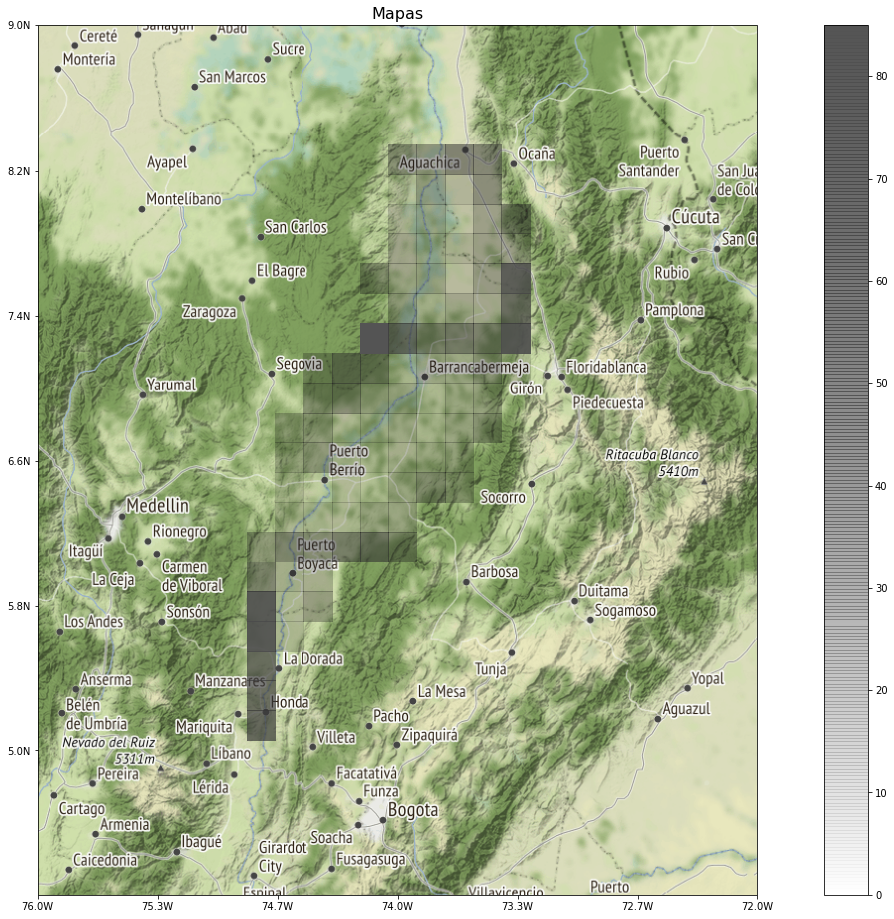

In [14]:
cimgt.Stamen.get_image = image_spoof # Realiza el llamado a la API
osm_img = cimgt.Stamen('terrain') # Descargar el mapa

fig = plt.figure(figsize=(24,16))
ax1 = plt.axes(projection=osm_img.crs) # Proyecta usando las coordenadas del sistema de referencia crs
ax1.set_title('Mapas',fontsize=16)
extent = [-76, -72, 4.2, 9] 
# extent = [-81.85, -66.854722, -4.214722, 13.383333] ## Mapa de Colombia
# lon_min, lon_max, lat_min, lat_max

# Configura el mapa
ax1.set_extent(extent) 
ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # Formata Latitud

ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud

scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # Cálculo empírico para obtener el zoom basado en la escala
scale = (scale<20) and scale or 19 # Escaliza la imagen (Renderización)
ax1.add_image(osm_img, int(scale)) # Adiciona la imagén y aplica el zoom

# Estima o histograma 2D de los campos
count, x_coord, y_coord = np.histogram2d(np.array(df['lon_t'], dtype=float), 
                                   np.array(df['lat_t'], dtype=float), bins = [10, 20])

# Registra el nuevo ColorMap
newCmap, nameNewCmap = registerColorMap(count, 'gray')
plt.register_cmap(cmap = newCmap)

# Inserta el histograma en el Mapa
im = ax1.pcolormesh(x_coord, y_coord, count.T, 
                    vmin = 0, 
                    vmax = int(count.max() + count.max()*0.0), 
                    cmap = nameNewCmap, 
                    transform=ccrs.PlateCarree()
                   )
plt.colorbar(im, ax = ax1)

plt.savefig(PATH_FIGURE + 'Mapa_eventos_v2.png', format='png', bbox_inches = 'tight' )